# Using Federated Learning with on CIFAR-100 using Sedna and PyTorch

This is the fifth practical exercise of our course [Applied Edge AI](https://learn.ki-campus.org/courses/edgeai-hpi2022).
In the last exercise, we implemented some parts of a Binary Neural Networks (BNNs) from scratch and trained a BNN for CIFAR-100 based on [BITorch](https://github.com/hpi-xnor/bitorch).
In this exercise we want to train a model with federated learning.
Each participant of the course represents one client that has only access to a limited (random) partition of the training data.
For this we first are going to implement a method that "guarantees" we have a unique split of the data.

Afterwards we are going to implement our own training loop and try to train in a federated manner with other participants based on the [Sedna framework](https://github.com/kubeedge/sedna).
We are very thankful to get support from the team developing [Sedna](https://github.com/kubeedge/sedna) for providing the actual server (since we are only dealing with the client side).
Thus, (as usual) please use the provided resources sensibly.

Similarly to the previous exercise, we provide you with a notebook with missing code sections.
In the graded quiz at the end of the week, we might ask some questions that deal with this exercise, so make sure to do the exercise (and have your output handy) **before** taking the quiz!

# How should we prepare the data?

As you might remember from this weeks' lecture videos, by training on edge devices we can make better use of local data for model training.
It also can gurantee a high degree of data privacy.
In this week we want to try one way of implementing this in a *Collaborative Training* approach.
But how can we best simulate different data sets if we actually have the whole dataset available?

The first idea could be to simply divide the dataset in equal halves, based on the number of clients like this:

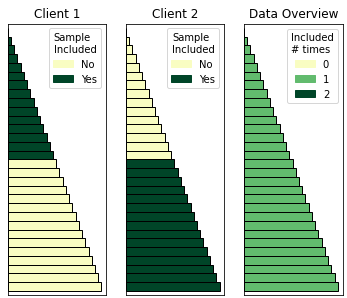

However in this exercise we want every participant to be one of the clients in our training scenario.
And we would need to define who gets which part of the data beforehand, which seems rather complicated.

Furtunately there is an alternative: we rely on "randomness".
But not completely random, instead we would like to use a unique seed for each participant, for example their birthdate.
This way, everyone gets a "random" part of the data, but each time we start a training it is going to use the same data ("our" clients data).
What we are going for, would then hopefully look a little bit like this:

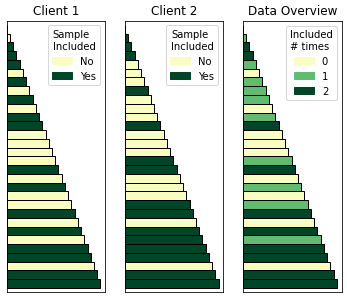

If we add additional clients with this strategy, they get randomly chosen data as well.
If we use the previous visualization for six clients (and assume random sampling based on a seed fixed per client), it would look like the following graph.
By using a fixed seed, we can also see, that Clients 1 and 2 get the same data "assigned" to them as in the previous example.

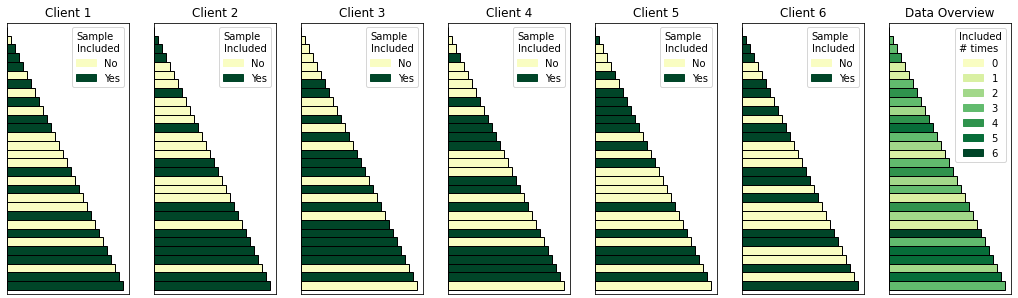

To achieve this result, we first need a way to get our random sample of the data.
Before we start with actual implementation, we provide you with a few functions you can use the visualize your results in the following code block (the code does not need to be changed).
We used these functions to create the visualizations above as well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def plot_order(data_arrays, labels, ylim=(0, 100)):
    assert len(data_arrays) == len(labels), "The function plot_order needs to receive the same number of data arrays and labels."
    fig, axes = plt.subplots(1, len(data_arrays), sharex=True, figsize=(min(len(labels) * 3, 18), 5), subplot_kw={"ylim": (ylim[0], ylim[1]+1), "xticks": [], "yticks":[]})

    y = np.arange(ylim[1], ylim[0], -1)
    for data, title, axis in zip(data_arrays, labels, axes.flatten() if len(data_arrays) > 1 else [axes]):
        axis.barh(y, data, height=1, fill=True)
        axis.set_title(title)

    plt.show()


def plot_selected_data(original, data_arrays, labels, ylim=(0, 100), colors=None, original_title="Data Overview", include_coverage=False):
    assert len(data_arrays) == len(labels), "The function plot_selected_data needs to receive the same number of data arrays and labels."
    fig, axes = plt.subplots(1, len(data_arrays) + 1, figsize=(min(len(labels) * 3, 18), 5), subplot_kw={"ylim": (ylim[0], ylim[1]+1), "xticks": [], "yticks":[]})
    
    colormap = plt.cm.get_cmap("YlGn")(np.linspace(0.1, 1.0, len(data_arrays) + 1))

    y = np.arange(ylim[1], ylim[0], -1)

    num_included = np.zeros_like(original)
    for data, title, axis in zip(data_arrays, labels, axes.flatten()[:-1]):
        in_data_split = np.zeros_like(original)
        in_data_split.put(data, 1)
        num_included += in_data_split
        in_data_split *= len(data_arrays)

        colors = {'No': colormap[0], 'Yes': colormap[len(data_arrays)]}         
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        axis.legend(handles, labels, title="Sample\nIncluded")

        axis.barh(y, original, height=1, fill=True, color=colormap[in_data_split], edgecolor="black")
        axis.set_title(title)

    axes[-1].barh(y, original, height=1, fill=True, color=colormap[num_included], edgecolor="black")
    axes[-1].set_title(original_title)

    colors = {str(i): colormap[i] for i in range(len(data_arrays)+1)}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    axes[-1].legend(handles, labels, title="Included\n# times")

    if include_coverage:
        print(f"{np.count_nonzero(num_included) / len(num_included)*100:.1f}% of the dataset were included by at least one client.")
    plt.show()
    
    
def dataset_for_seed(seed, num_elements, fraction=1/2):
    data = np.arange(0, num_elements)
    labels = np.arange(0, num_elements)
    return parallel_seeded_choice([data, labels], seed, int(num_elements * fraction))

# Task 1: Selecting "Random" Data and Labels

Fortunately, the numpy library provides a very useful method [*choice*](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) to select values from an existing array randomly.
For the first task you can look at the documentation and figure out, how to use this method to create two equal subsets of a given dataset.
One of the optional arguments is quite important for our use case.

Another important point here is: we need to choose the same "elements" (in the same order) for both the *data* array and the *label* array.
For example, if we chose data sample at the indices 1,3,5, and 7, we also need to choose the corresponding labels 1,3,5, and 7.
Therefore, after running the following code cell and implementing the function correctly, both the "Labels" and the "Data" should be equal.

In [27]:
def parallel_seeded_choice(array_list, seed, n):
    # `array_list` is a list (or tuple) of all arrays from which `n` elements should be chosen randomly, based on the `seed`

    chosen_data_splits = []
    # TODO: use the default random number generator of numpy with the seed, then chose n elements from each array in the list, finally return the result
    # HINT: our function should work with any number of arrays (args is a list of arrays)
    # TASK START - Start coding here:
    rng = np.random.default_rng(seed)
    chosen_idx = rng.choice(np.arange(array_list[0].shape[0]),size=n, replace=False)
    chosen_data_splits.append(np.array(array_list[0])[chosen_idx])
    chosen_data_splits.append(np.array(array_list[1])[chosen_idx])
    
    return chosen_data_splits
    
# visual test case:
num_elements = 30
fraction = 1/2
seed = 42

client_data, client_label = dataset_for_seed(seed, num_elements, fraction=fraction)
print(f"Data (seed={seed}):  ", client_data)
print(f"Labels (seed={seed}):", client_label)
plot_selected_data(np.arange(0, num_elements), [client_data, client_label], [f"Data (seed={seed})", f"Labels (seed={seed})"], ylim=(0, num_elements))

The output of the previous code should start with
```
Data (seed=42):   [ 1  2 11 22  4 29 21 20  8 18 19 25 13 16 26]
Labels (seed=42): [ 1  2 11 22  4 29 21 20  8 18 19 25 13 16 26]
```
followed by a figure showing three equal-looking subgraphs. If you want you can also experiment a bit with different seeds, number of elements or fraction of the data chosen.

Note, that there are *many other and different ways* of implementing what we need, but we also need all participants to use the same method, otherwise we still may not achieve the intended result.
Therefore we suggest you also check our simple numeric test case in the following code cell. If your solution passes our test, it will simply print `Test passed.` If it does not work, you will get an error. In this case you need to fix the code above. (And do not forget to run the above code cell again!)

If you need help to understand the problem you can uncomment the print statements in the code below and look at the output before the error.

In [28]:
# do not change the test seed and length
TEST_SEED = 42
TEST_LENGTH = 8
for test_arrays in [(np.arange(10), np.arange(10)), (np.arange(10), np.arange(10), np.arange(10))]:
    #print("Arrays before randomly choosing with fixed seed:", test_arrays)
    test_arrays = parallel_seeded_choice(test_arrays, TEST_SEED, TEST_LENGTH)
    #print("Arrays after randomly choosing with fixed seed: ", test_arrays)

    assert len(test_arrays[0]) == TEST_LENGTH, f"The arrays do not have the correct length {TEST_LENGTH}."
    assert len(test_arrays[0]) == len(np.unique(test_arrays[0])), "Problem: there are duplicate values in the array. We do not want to include a data sample twice."
    for i in range(1, len(test_arrays)):
        assert np.allclose(test_arrays[0], test_arrays[i]), f"The elements from arrays 0 and {i} were not chosen in the same way."
    assert np.allclose(np.array([8, 9, 7, 4, 6, 2, 0, 3]), test_arrays[0]), "The elements from arrays were not chosen correctly based on TEST_SEED=42."
print("Test passed.")

Finally, we need to ensure that every participant uses a (hopefully) unique random seed.
Thus we propose to use our birthdate (formatted as an integer).
Please set it below and check the very basic example.

We should use the same `MY_RANDOM_SEED` variable later on in the code for our dataset.

In [29]:
# TODO: Store your birthdate as one integer in the format YYYYMMDD in the variable `MY_RANDOM_SEED`.
#       This ensures that (hopefully) everyone in the course has a different random seed and thus different share of data.
# TASK START - Start coding here:
MY_RANDOM_SEED = 19891217

test_arrays = np.arange(10), np.arange(10)
print("Arrays before randomly choosing with fixed seed:", test_arrays)
test_arrays = parallel_seeded_choice([test_arrays[0], test_arrays[1]], MY_RANDOM_SEED, 5)
print("Arrays after randomly choosing with fixed seed: ", test_arrays)
assert np.allclose(test_arrays[0], test_arrays[1]), "Arrays are not chosen the same way."
print("Test passed.")

Finally, we though it might be cool to experiment a bit with our implementation so far.
The code below simulates a dataset with a certain number of clients and training data.
You could use to experiment with different fractions of the dataset and number of clients.

For example, you can check how many clients you *approximately* need, so at least 80 % of the dataset is included by at least one client, if you use half, one third, or one fourth of the data.
(If you know how to calculate this propability, you can of course also calculate it.) 

In [30]:
num_elements = 30
num_clients = 2
fraction = 1/3

orig_order = np.arange(0, num_elements)
clients_data = []
data_title = []
for i in range(num_clients):
    new_data, _ = dataset_for_seed(i, num_elements, fraction=fraction)
    data_title.append(f"Client {i+1}")
    clients_data.append(new_data)

plot_selected_data(orig_order, clients_data, data_title, ylim=(0, num_elements), include_coverage=True)

# Task 2: Adapting our Data Loader

The following section should look familiar to previous exercises.
But this time, we need to add our "random" (based on our fixed seed - our birthday) selection so we only use part of the dataset.
To get more accurate results, we decided everyone should use all test data, but in practice the test data could also be different between different clients.

Thus in the following we have added the `train` argument to our class `CIFAR100Partition`.
If it is `False` we should not randomly chose part of the dataset.
However if it is `True`, we can apply the `parallel_seeded_choice` function we implemented above to select **half** of the training data.
Remember, that both the data and the labels should be chosen by one call of our function so they are both chosen in the same way (and the data and labels still correspond to each other).

In [32]:
from pickle import load as pload

from torchvision import transforms as tt
from typing import Optional
from imgaug import augmenters as iaa
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset

class CIFAR100Partition(Dataset):
    def __init__(self, dataset_path: Path, image_transforms: tt.Compose, train: bool = True,
                 image_augmentations: Optional[iaa.Sequential] = None):
        super().__init__()
        data = pload(dataset_path.open("rb"), encoding="bytes")
        self.images = data[b"data"]
        self.labels = data[b"fine_labels"]

        assert len(self.images) == len(self.labels), "Number of images and labels is not equal!"

        self.image_transforms = image_transforms
        self.image_augmentations = image_augmentations

        # TODO: 
        #     1) training data: randomly choose *half* of the images and labels based on the seed stored in the variable `MY_RANDOM_SEED`
        #     2) testing data: do nothing for them (i.e. return immediately)
        # HINTS:
        #     - check the `train` variable to find out which kind of data we are currently loading
        #     - for the training data: overwrite the self.images and self.labels with the values returned by our function
        # TASK START - Start coding here:
        if train:
            self.images, self.labels = parallel_seeded_choice([self.images, self.labels], 
                                                              MY_RANDOM_SEED, 
                                                             int(len(self.images)/2))
        
        assert len(self.images) == len(self.labels), "Number of images and labels is not equal!"

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> tuple:
        image = self.images[index]
        label = self.labels[index]

        image = np.reshape(image, (3, 32, 32))
        image = np.transpose(image, (1, 2, 0))

        if self.image_augmentations is not None:
            image = self.image_augmentations.augment_image(image)
        image = self.image_transforms(Image.fromarray(image))
        return image, label


image_transformations = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(
        mean=(0.5074, 0.4867, 0.4411),
        std=(0.2011, 0.1987, 0.2025)
    )
])

train_augmentations = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.CropAndPad(px=(-4, 4), pad_mode="reflect")
])
cifar_train_set = CIFAR100Partition(Path("/kaggle/input/cifar100/train"), image_transformations, image_augmentations=train_augmentations)
cifar_test_set = CIFAR100Partition(Path("/kaggle/input/cifar100/test"), image_transformations, train=False)

print("Number of training samples:", len(cifar_train_set))
print("Number of test samples:    ", len(cifar_test_set))

assert len(cifar_train_set) == 25000, "We should use 25000 training samples (half of all data)."
assert len(cifar_test_set) == 10000, "We should use all 10000 test samples."

If everything was implemented correctly, you should see the following output (and no error):
```
Number of training samples: 25000
Number of test samples:     10000
```
Of course we can not test very well, whether you used the correct seed, so please double check, whether you use `MY_RANDOM_SEED` (your birthdate encoded as an integer) as the seed.

# Federated Learning with Sedna

Now, after we have modelled different data splits for each participant, we can start implementing the actual federated learning.
As mentioned at the beginning of the exercise, we are using [Sedna](https://github.com/kubeedge/sedna).
We have already included the source coded needed as an input to this notebook, but we need to install some requirements first in the following code block.
We also want to configure the logging, so we can see the output in our notebook.

To allow installation of packages, you need to have *your phone number verified* [in your Kaggle profile](https://www.kaggle.com/me/account). Then you can enable the Internet switch in the sidebar on the right (you can open the sidebar by clicking on the |< Symbol in the top right, then select Settings, Internet). The switch should show a checkmark afterwards.

Furthermore we need to specificy a few environment variables so [Sedna](https://github.com/kubeedge/sedna) knows which server to connect to later on (IP, Port, and names to categorize our experiment).
We have encapsulated this in a utility script, which we import in the following code cell.

In [33]:
!pip install -r /kaggle/input/kubeedge-sedna/lib/requirements.txt
import sys
sys.path.append('/kaggle/input/kubeedge-sedna/lib')

# configure logging for kaggle
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format='%(filename)s:%(lineno)s %(levelname)s:%(message)s')

import nest_asyncio
nest_asyncio.apply()

# this sets a few internal configuration variables for sedna
import edge_ai_w5_sedna_configuration

## Adapting the Federated Learning Logic

Now that we have installed the library we can dive into the details.
Sedna internally can use [plato](https://github.com/TL-System/plato) and has integrated functions that make use of it.
Plato uses (among others) the concepts of a **client** (which manages communication to the server and triggers the training) and a **trainer** (which provides the training loop logic).
In the following, we are going to present the standard federated learning process and we want to change in this practical exercise (marked with *TODO:*):

1. Clients: are initialized and register at the server
2. Server: receives client registrations, waits until enough clients are connected
3. Server: starts the training process, initializes the model with random weights
    1. Server: starts the next round, sends the weights and the current round number to each client chosen for training
    2. Clients: receive the current model (*TODO: and the current round number*)
    3. *TODO: Clients: calculate and print test accuracy on the test data*
    3. Clients: start training for one round (5 epochs in our case) (*TODO: adapt learning rate according to the current round number*)
    3. Clients: calculate test accuracy on the test data
    4. Clients: send the accuracy and the updated model weights to the server
    5. Server: aggregates all models received from the clients, calculates average accuracy
    6. Server: finish training if either target accuracy is achieved or total number of rounds, otherwise loop to A.

We want to make these adaptations, since in our scenario our clients are very independent from our server, they might start at any time, and only a few clients are chosen for every round.
Thus, if a lot of rounds were already trained (e.g. by other clients), we want to use a lower learning rate, than if we participate in the first rounds.
Also we would like to receive feedback immediately, and compare the accuracy between the weights sent by the server and the weights after training for one round.

To make these adaptations we need register our own Trainer class `EdgeAiTrainer` (based on the `BasicTrainer` provided by plato) and Client class `EdgeAiClient` (based on the `SimpleClient` provided by Plato) in the following code cells.
These can then be used for training with Sedna.

# Task 3: Adapt the Trainer

First, we want to adapt the *trainer*.
We have extended the `BasicTrainer` below, which allows us to modify only what we want to modify.
In this case, we want to implement the `get_optimizer` method, so it uses a lower learning rate for when our client participates in later training rounds.

The goal of this exercise is to use the original learning rate for the first 20 rounds (so 100 epochs in total),
then use a lower learning rate equal to one tenth of the original learning rate for the next 20 rounds (so epochs 100 - 200) and finally use a learning rate equal to one hundredth of the original learning for the final 10 rounds.
(Note that the first round is round 1, not round 0.)

Also, we want every participant to be able to participate, so we already prepared code, which stops the training process after one round.
The line responsible is `raise ValueError("Stopping training after early after one epoch.")` which tells the client to disconnect from the server, instead of starting a second round of training.
Therefore, we want to save our model weights after the first round, but we have also already prepared the code for this.

In [41]:
from plato.trainers import registry as trainer_registry
from plato.trainers.basic import Trainer as BasicTrainer

from plato.config import Config
from plato.utils import optimizers

from torch import optim


class EdgeAiTrainer(BasicTrainer):
    def __init__(self, model=None):
        super(EdgeAiTrainer, self).__init__(model)
        self.current_round = -1
        self.current_learning_rate = 0
        self.first_round = True

    def get_optimizer(self, model):
        "customize SGD with our own computed learning rate. other optimizers can be retrieved from the default method."
        logging.info(f"[Edge AI Trainer] Using lr={self.current_learning_rate:.5f} (in round {self.current_round}).")
        assert self.current_learning_rate > 0, "the learning rate was not set correctly, it should be larger than 0"
        assert self.current_learning_rate <= Config().trainer.learning_rate, "the learning rate should never be increased"
        if Config().trainer.optimizer == 'SGD':
            return optim.SGD(
                model.parameters(),
                lr=self.current_learning_rate,
                momentum=Config().trainer.momentum,
                weight_decay=Config().trainer.weight_decay
            )
        return optimizers.get_optimizer(self.model)

    def set_learning_rate(self):
        initial_learning_rate = Config().trainer.learning_rate
        # TODO: calculate the current learning rate, and store it in self.current_learning_rate
        #       the rate should be:
        #           1 * initial_learning_rate     for rounds 1  through 20
        #           1/10 * initial_learning_rate  for rounds 21 through 40
        #           1/100 * initial_learning_rate for rounds 41 through 50
        # TASK START - Start coding here:
        self.current_learning_rate = 1 / 10**(int( (self.current_round - 1) / 20)) * initial_learning_rate

    def train(self, trainset, sampler, cut_layer=None) -> float:
        if not self.first_round:
            raise ValueError("Stopping training after early after one epoch.")
        assert self.current_round >= 0, "the current round of the trainer was not correctly set by the client"
        self.set_learning_rate()
        logging.info("[Edge AI Trainer] Start training.")
        training_time = super().train(trainset, sampler, cut_layer=cut_layer)
        logging.info("[Edge AI Trainer] Finished training, saving the model.")
        self.save_model()
        self.first_round = False
        return training_time


trainer_registry.registered_trainers["edge_ai_trainer"] = EdgeAiTrainer

If you look into the code above once more, you will also see the line: `self.current_round = -1`.
This is never changed within our trainer (it does not know the current round).
Instead, we need to set up our client, so it modifies this value after receiving it from the server.

You can check whether you implemented the learning rate computation correctly below:

In [42]:
eat = EdgeAiTrainer()
expected_lrs = [0.01]*20 + [0.001]*20 + [0.0001]*10
for i, lr in enumerate(expected_lrs):
    eat.current_round = i+1
    eat.set_learning_rate()
    assert eat.current_learning_rate == lr, f"The learning rate at round {eat.current_round} should be {lr}, but is {eat.current_learning_rate} instead."
print("Test passed.")

# Task 4: Adapt the Client

Secondly, we want to adapt the *client*.
Again, we have extended the `SimpleClient` below, which allows us to modify only what we want to modify.
However in this case it may be helpful to look at corresponding parts of the original code.
Try to find out, where and how the testing is done, and how the weights are usually loaded from the payload. 

In [43]:
with open('/kaggle/input/kubeedge-sedna/lib/plato/clients/simple.py') as handle:
    content = handle.read().splitlines()
    print("\n".join(["# [...]"] + content[24:26] + ["# [...]"] + content[86:118] + ["# [...]"]))

In the following code we now want to adapt two things:

1. Deal with the adapted payload (it also includes the round number)
2. Calculate the test accuracy before a training round

## Task 4a): Deal with the adapted payload

The pseudocode for the payload on the server has been adapted like the following code segment, so it includes the *current round*:

    def construct_server_payload(self):
        """ Construct the server payload before sending to the client. """
        payload = {"weights": self.algorithm.extract_weights(), "current_round": self.current_round}
        return payload

On our client side we now also need to deal with the received payload correctly and load the weights (which were extracted on the server) into our own algorithm.
Also we want to set the `current_round` of our trainer, so it can calculate the learning rate correctly (we have already finished this part).
If you need help with loading the weights, please check the code of the original implementation of `load_payload` in a `SimpleClient`.

## Task 4b): Calculate the accuracy before a training round

This should be quite easy as well if you look at the original implementation of the `SimpleClient`.
There is already code, that computes the accuracy on the test data, but it is only run after the training.
You can copy this code and insert it below before we run the `train()` method of the super class `SimpleClient`.

This way we will run the test data before the training (and internally it will also be run after the training).

In [53]:
from plato.clients import registry as client_registry
from plato.clients.simple import Client as SimpleClient


class EdgeAiClient(SimpleClient):
    def load_payload(self, server_payload) -> None:
        """Load the server model onto this client and store current rounds in the trainer."""
        # Task 4a)
        # TODO: load the weights into the algorithm and save the current rounds for our trainer
        # HINT: payload is a dictionary with two key value pairs:
        #         "weights"       - the weights to be loaded into `self.algorithm`
        #         "current_round" - the current round (on the server) which needs to be saved in `self.trainer`
        # TASK START - Start coding here:
        self.trainer.current_round = server_payload["current_round"]
        self.algorithm.load_weights(server_payload["weights"])
        
    def extra_test(self):
        accuracy = 0
        # Task 4b)
        # TODO: check how the SimpleClient tests the model on the test data and paste the code to do so here
        # HINT: one line is enough and the returned accuracy should be stored in the variable `accuracy` so it can be returned
        # TASK START - Start coding here:
        accuracy = self.trainer.test(self.testset)
        return accuracy

    async def train(self):
        logging.info("[Client #%d] Do a validation pass before training.", self.client_id)
        accuracy = self.extra_test()
        if accuracy == 0:
            # The testing process failed, disconnect from the server
            await self.sio.disconnect()
        logging.info("[Client #{:d}] Test accuracy: {:.2f}%".format(self.client_id, 100 * accuracy))
        return await super().train()


client_registry.registered_clients["edge_ai_client"] = EdgeAiClient

The following test case can be used to test, whether you implemented the previous tasks correctly.
Since testing the client without actually attempting to connect to the server, we are using mock objects for this test case.

In [54]:
from unittest.mock import MagicMock, patch

mock_testset, mock_weights = MagicMock(name="test set"), MagicMock(name="model weights")

eac = EdgeAiClient()
eac.algorithm, eac.trainer, eac.testset = MagicMock(name="algorithm"), MagicMock(name="trainer"), mock_testset
eac.trainer.test.return_value = 21

eac.load_payload({"weights": mock_weights, "current_round": 42})
assert eac.trainer.current_round == 42, "The current_round was not stored correctly in the trainer when loading the payload."
assert len(eac.algorithm.method_calls) == 1, "Too many or few methods were called on the algorithm (it should only be one)."
assert eac.algorithm.method_calls[0][0] == "load_weights", "The wrong function was called on the algorithm to load the weights."
assert len(eac.algorithm.method_calls[0][1]) == 1, "The `load_weights` function called on the algorithm should receive exactly one argument."
assert eac.algorithm.method_calls[0][1][0] == mock_weights, "The `load_weights` function called on the algorithm has not received the correct argument."
assert len(eac.algorithm.method_calls[0][2]) == 0, "The `load_weights` function called on the algorithm should not receive any keyword arguments."

result = eac.extra_test()
assert result == 21, "The extra_test does not seem to return the correct accuracy."
assert len(eac.trainer.method_calls) == 1, "Too many or few methods were called on the trainer (it should only be one)."
assert eac.trainer.method_calls[0][0] == "test", "The wrong function was called on the trainer to test on the test data."
assert len(eac.trainer.method_calls[0][1]) == 1, "The `test` function called on the trainer should receive exactly one argument."
assert eac.trainer.method_calls[0][1][0] == mock_testset, "The `test` function called on the trainer has not received the correct argument."
assert len(eac.trainer.method_calls[0][2]) == 0, "The `test` function called on the trainer should not receive any keyword arguments."

print("Test passed.")

Furthermore, we need to encapsulate our dataset in a class structure, which provides the `trainset` and `testset` member variables, as well as having `customized` have set to `True`.
Finally, Sedna expects an Estimator to provide configuration options for the training process, and the model that should be used for training.
Based on your experience from previous exercise, some options should already be familiar to you.
Others are specifically for federated learning, we have added comments to them to describe what they do.

You should not change the hyperparameters here, because every client should use the same hyperparameters.

In [55]:
import cifar100_resnets as models


class CustomDataset:
    def __init__(self, trainset, testset) -> None:
        self.customized = True
        self.trainset = cifar_train_set
        self.testset = cifar_test_set


class Estimator:
    def __init__(self) -> None:
        self.model = self.build()
        self.pretrained = None
        self.saved = None
        # select our custom client
        self.use_client = "edge_ai_client"
        self.hyperparameters = {
            # select our custom trainer
            "type": "edge_ai_trainer",
            # train for 50 rounds, each round consists of multiple epochs, average the model and accuracy between all clients after each round 
            "rounds": 50,
            # stop training early if we achieve an average accuracy of at least 60 % between all clients
            "target_accuracy": 0.6,
            # train for 5 epochs each round
            "epochs": 5,
            "batch_size": 128,
            "optimizer": "SGD",
            "learning_rate": 0.1,
            "model_name": "cifar100_resnet",
            "momentum": 0.9,
            "weight_decay": 1e-4
        }

    @staticmethod
    def build():
        return models.resnet20(num_classes=100)

# Start the Federated Learning

Now, we just need to perform the last setup steps and can then connect to the server to (hopefully) start the training. \O/

In this exercise you can decide for yourself, whether you want to enable GPU acceleration based on the number of available hours left.
The training process will also run without GPU but a little bit slower.

However (!), this time we need to wait for at least one other client to connect to the server.
The server will not start training unless at least **two** clients are connected.
Similarly if a round was *already* started (with other clients), before our client connects, we need to wait for the current round to finish.
So: be patient and wait for the process to start.
The expected output, until another client arrives should look like this:

    registry.py:31 INFO:Client: edge_ai_client
    registry.py:39 INFO:Trainer: edge_ai_trainer
    registry.py:46 INFO:Algorithm: fedavg
    base.py:119 INFO:[Client #956099267] Contacting the central server.
    base.py:148 INFO:[Client #956099267] Connecting to the server at http://159.138.44.120:30363.
    base.py:40 INFO:[Client #956099267] Connected to the server.
    base.py:152 INFO:[Client #956099267] Waiting to be selected.
   
If there are no other clients from other course participants, you can also create a copy of your own Kaggle notebook, and start two (CPU) processes at the same time.
In this case: do not forget to enter a different date into `MY_RANDOM_SEED`.
Be careful though: if a round is *already* running, both notebooks are going to wait until the current round is finished.
One round should not take longer than 15 minutes.

If you get a connection error after starting, the server might currently be unavailable.
We are going to monitor the server status, and try to make it available while the course is still running, however we can not guarantee 100% availability.

Note that if you *disconnect from the server* (whether by cancelling the run or waiting for it to finish), Sedna stops the complete Python process, which means we *need to run all previous cells again* to train another time.

In [ ]:
from sedna.algorithms.aggregation import FedAvgV2
from sedna.core.federated_learning import FederatedLearningV2

# create an instance of our dataset
our_dataset = CustomDataset(trainset=cifar_train_set, testset=cifar_test_set)
# create an instance of our estimator
estimator = Estimator()
# our aggregation method
fedavg = FedAvgV2()
# get configured model transmitter
transmitter = FederatedLearningV2.get_transmitter_from_config()

fl = FederatedLearningV2(
    data=our_dataset,
    estimator=estimator,
    aggregation=fedavg,
    transmitter=transmitter)
fl.train()

If the training successfully starts, the log output should look like this (we omitted the first part of the log output until the client ist selected by the server):

    base.py:165 INFO:[Client #3387094852] Selected by the server.
    simple.py:60 INFO:[Client #3387094852] Loading its data source...
    simple.py:67 INFO:[Client #3387094852] Dataset size: 25000
    registry.py:47 INFO:[Client #3387094852] Sampler: all_inclusive
    base.py:176 INFO:on_payload
    base.py:193 INFO:on_payload_done
    base.py:211 INFO:[Client #3387094852] Received 1.09 MB of payload data from the server.
    train_cifar_on_kaggle.py:316 INFO:[Client #3387094852] Do a validation pass before training.
    train_cifar_on_kaggle.py:321 INFO:[Client #3387094852] Test accuracy: 49.12%
    simple.py:93 INFO:[Client #3387094852] Started training.
    train_cifar_on_kaggle.py:278 INFO:[Edge AI Trainer] Start training.
    basic.py:116 INFO:[Client #3387094852] Loading the dataset.
    train_cifar_on_kaggle.py:245 INFO:[Edge AI Trainer] Using lr=0.10000 (in round 5).
    basic.py:190 INFO:[Client #3387094852] Epoch: [1/5][0/196]	Loss: 1.575893
    basic.py:190 INFO:[Client #3387094852] Epoch: [1/5][10/196]	Loss: 1.648850
    basic.py:190 INFO:[Client #3387094852] Epoch: [1/5][20/196]	Loss: 1.569763

If this is the case you can let the training finish.
Once you have trained for one round, the training process should stop automatically and the process should disconnect from the server.
Afterwards you can do another round, or leave the rest of the training to other participants.
If the training actually finishes (after 50 rounds or 60% accuracy), the server should restart and allow a new training process to start.

# What now?

Since we could not really try this training without many participants, we can not provide you with an expected accuracy.
It is a bit of an experiment, which we hope is going to work out.
In any case it should provide you with a lot more hand-on experience on how federated learning works.
We hope you also gained a bit of insight into [Sedna](https://github.com/kubeedge/sedna).

If you are interested, you can try loading the saved model (it should be saved at `./models/pretrained/cifar100_resnet.pth` after each round) and running the test data through it locally.

You can also dig deeper into the [Sedna code](https://github.com/kubeedge/sedna) and try to understand how other training scenarios can work.